# Lab 5: Grouping, Aggregation, Pivot Tables, and DataFrame Manipulation in Pandas

This lab focuses on how to summarize, reshape, and manipulate tabular and time-series data using Pandas.

## Learning Objectives
- Understand and apply `groupby()` and `.agg()` for data summarization
- Use `.resample()` for time-based grouping
- Create and manipulate pivot tables
- Modify DataFrames by adding, transforming, and filtering columns
- Sort and rank data based on values
- Practice using these techniques in exercises

## 1. Create a Time Series Dataset
We begin by creating a small dataset simulating greenhouse sensor data, including temperature and CO2 levels over 12 days.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed for reproducibility so results are the same each run
np.random.seed(0)

# Create a sequence of 12 daily dates starting from 2024-01-01
date_rng = pd.date_range(start='2024-01-01', periods=12, freq='D')

# Simulate greenhouse sensor data:
# - 'Greenhouse': which greenhouse the reading is from (A, B, or C)
# - 'Temperature': random integer temperature values between 20 and 30°C
# - 'CO2': random integer CO2 levels between 400 and 450 ppm
data = {
    'Date': date_rng,
    'Greenhouse': ['A', 'B', 'A', 'C', 'A', 'B', 'C', 'A', 'C', 'B', 'A', 'C'],
    'Temperature': np.random.randint(20, 30, size=12),
    'CO2': np.random.randint(400, 450, size=12)
}

# Create a DataFrame from the simulated data
df = pd.DataFrame(data)

# Set 'Date' as the index so time-based operations (like resampling) are easier
df.set_index('Date', inplace=True)

# Display the resulting DataFrame
df

,Greenhouse,Temperature,CO2
Date,,,
2024-01-01,A,25,424
2024-01-02,B,20,424
2024-01-03,A,23,412
2024-01-04,C,23,401
2024-01-05,A,27,438
2024-01-06,B,29,439
2024-01-07,C,23,423
2024-01-08,A,25,446
2024-01-09,C,22,424


## 2. Grouping with `groupby()`
`groupby()` allows you to group data by categories (e.g., greenhouse ID) and compute summary statistics for each group.

**Example:**  
Grouping the DataFrame by 'Greenhouse' and calculating the mean for 'Temperature' and 'CO2':

- `df.groupby('Greenhouse')`: Splits the data into groups based on the 'Greenhouse' column.
- `[['Temperature', 'CO2']]`: Selects only the 'Temperature' and 'CO2' columns for aggregation.
- `.mean()`: Calculates the average value for each column within each group.

The result is a new DataFrame showing the mean temperature and CO2 level for each greenhouse.

In [ ]:
df.groupby('Greenhouse')[['Temperature', 'CO2']].mean()

,Temperature,CO2
Greenhouse,,
A,25.400000,431.400000
B,24.333333,426.666667
C,23.500000,418.250000


## 3. Multiple Aggregations with `.agg()`
With `.agg()`, you can apply multiple aggregation functions (like mean, max, min, std) to each group.

**Example:**  
Grouping by 'Greenhouse' and applying multiple aggregations to 'Temperature' and 'CO2':

- `df.groupby('Greenhouse').agg({...})` splits the DataFrame into groups based on the 'Greenhouse' column and applies different aggregation functions to each column:
    - For **Temperature**: calculates the mean, max, and min for each greenhouse group.
    - For **CO2**: calculates the mean and standard deviation for each greenhouse group.
- The result is a DataFrame with hierarchical column labels showing the computed statistics for each greenhouse.

This approach is useful when you want to see several summary statistics for each group at once.


In [ ]:
df.groupby('Greenhouse').agg({
    'Temperature': ['mean', 'max', 'min'],
    'CO2': ['mean', 'std']
})

Temperature                 CO2           
                  mean max min        mean        std
Greenhouse                                           
A            25.400000  27  23  431.400000  13.408952
B            24.333333  29  20  426.666667  11.239810
C            23.500000  26  22  418.250000  11.528949

### Explanation of `df.resample('W').mean(numeric_only=True)`

- **`df.resample('W')`**: This method groups the DataFrame into weekly bins, using the datetime index (`Date`). `'W'` stands for "week", so each group contains all rows from the same week.
- **`.mean(numeric_only=True)`**: After grouping, this calculates the mean (average) of all numeric columns (`Temperature` and `CO2`) for each week. The `numeric_only=True` argument ensures only numeric columns are included in the calculation, ignoring any non-numeric columns.

**Result:**  
You get a new DataFrame where each row represents a week, and the columns show the average temperature and CO2 for that week. This is useful for summarizing trends over time, such as seeing how greenhouse conditions change week by week.

In [17]:
df.resample('W').mean(numeric_only=True)

,Temperature,CO2
Date,,
2024-01-07,24.285714,423.0
2024-01-14,24.800000,429.8


## 5. Pivot Table

A **pivot table** lets you reorganize and summarize data, making it easier to compare values across categories. In pandas, `pivot_table()` is used to reshape data so that one variable becomes columns, another becomes rows, and you can display values for each combination.

**In this example:**
- We use `pd.pivot_table()` to show how temperature readings vary by greenhouse and date.
- The `values='Temperature'` argument tells pandas to fill the table with temperature values.
- The `index='Date'` argument makes each row represent a different date.
- The `columns='Greenhouse'` argument creates separate columns for each greenhouse (A, B, C).

**Result:**  
You get a table where each row is a date, each column is a greenhouse, and the cell values are the recorded temperatures. If a greenhouse didn't record a temperature on a certain date, the cell will show `NaN` (missing value).

This format makes it easy to compare temperature trends across greenhouses over time.

In [5]:
pivot = pd.pivot_table(df, values='Temperature', index='Date', columns='Greenhouse')
pivot

Greenhouse,A,B,C
Date,,,
2024-01-01,25.0,NaN,NaN
2024-01-02,NaN,20.0,NaN
2024-01-03,23.0,NaN,NaN
2024-01-04,NaN,NaN,23.0
2024-01-05,27.0,NaN,NaN
2024-01-06,NaN,29.0,NaN
2024-01-07,NaN,NaN,23.0
2024-01-08,25.0,NaN,NaN
2024-01-09,NaN,NaN,22.0


## 6. Handling Missing Values in Pivot Tables
Fill missing combinations with a default value (e.g., 0).

When you create a pivot table, some combinations of row and column labels may not exist in the original data, resulting in missing values (`NaN`). This is common when, for example, a greenhouse did not record a temperature on a particular date.

To make the table easier to read or to prepare it for further analysis, you can replace these missing values with a default value using the `.fillna()` method. For example, `pivot.fillna(0)` will fill all `NaN` cells in the pivot table with 0.

This is especially useful when you want to perform calculations or visualizations that require complete data, or when you want to highlight the absence of data with a specific value.

In [18]:
pivot.fillna(0)

Greenhouse,A,B,C
Date,,,
2024-01-01,25.0,0.0,0.0
2024-01-02,0.0,20.0,0.0
2024-01-03,23.0,0.0,0.0
2024-01-04,0.0,0.0,23.0
2024-01-05,27.0,0.0,0.0
2024-01-06,0.0,29.0,0.0
2024-01-07,0.0,0.0,23.0
2024-01-08,25.0,0.0,0.0
2024-01-09,0.0,0.0,22.0


## 7. Visualize Grouped and Pivoted Data
Data visualization can help identify trends and compare values more clearly.

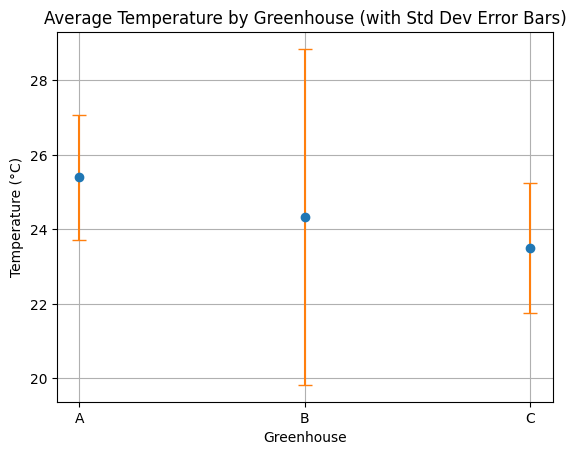

In [19]:
# Calculate mean and standard deviation of temperature for each greenhouse
means = df.groupby('Greenhouse')['Temperature'].mean()
stds = df.groupby('Greenhouse')['Temperature'].std()

# Plot using error bars
plt.errorbar(
    means.index,         # Greenhouse labels (x-axis)
    means.values,        # Mean temperatures (y-axis)
    yerr=stds.values,    # Error bars (standard deviation)
    fmt='o',             # Marker style
    capsize=5,           # Adds caps to error bars for clarity
    color='tab:blue',    # Line and marker color
    ecolor='tab:orange'  # Error bar color
)
plt.title('Average Temperature by Greenhouse (with Std Dev Error Bars)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Greenhouse')
plt.grid(True)
plt.show()

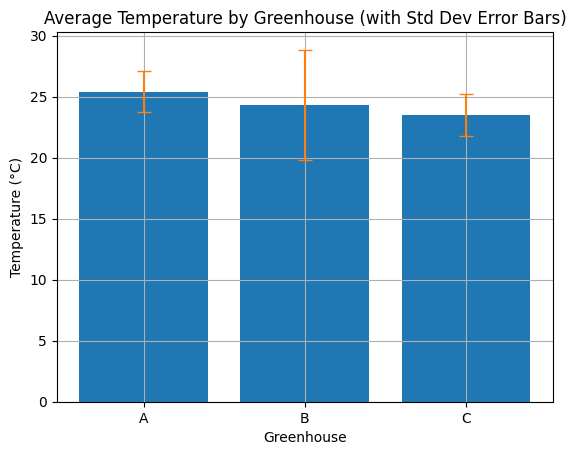

In [20]:
# Bar chart showing average temperature for each greenhouse, with error bars for standard deviation
plt.bar(
    means.index,        # Greenhouse labels on x-axis
    means.values,       # Mean temperatures on y-axis
    yerr=stds.values,   # Error bars represent standard deviation
    capsize=5,          # Adds caps to error bars for clarity
    color='tab:blue',   # Bar color
    ecolor='tab:orange' # Error bar color
)
plt.title('Average Temperature by Greenhouse (with Std Dev Error Bars)')  # Chart title
plt.ylabel('Temperature (°C)')                                            # Y-axis label
plt.xlabel('Greenhouse')                                                  # X-axis label
plt.grid(True)                                                            # Show grid for readability
plt.show()                                                                # Display the plot

## 8. Filtering with Conditions Before Grouping
You can filter rows before applying a groupby, for example selecting only rows with CO2 < 430.

In [9]:
df[df['CO2'] < 430].groupby('Greenhouse')['Temperature'].mean()

Greenhouse
A    24.0
B    22.0
C    23.5
Name: Temperature, dtype: float64

This code filters the DataFrame `df` to include only rows where the CO2 value is less than 430. Then, it groups these filtered rows by the 'Greenhouse' column and calculates the mean temperature for each greenhouse.

**Step-by-step:**
1. `df[df['CO2'] < 430]`: Selects only rows where CO2 is less than 430.
2. `.groupby('Greenhouse')`: Groups the filtered rows by greenhouse ('A', 'B', or 'C').
3. `['Temperature'].mean()`: For each group, computes the average temperature.

**Result:**  
You get the mean temperature for each greenhouse, considering only the days when CO2 was below 430.

## 9. Adding and Modifying Columns
You can create new columns by applying arithmetic operations to existing ones. Let's convert Celsius to Fahrenheit.

In [23]:
df['Temp_F'] = df['Temperature'] * 9/5 + 32
df[['Temperature', 'Temp_F']]

,Temperature,Temp_F
Date,,
2024-01-01,25,77.0
2024-01-02,20,68.0
2024-01-03,23,73.4
2024-01-04,23,73.4
2024-01-05,27,80.6
2024-01-06,29,84.2
2024-01-07,23,73.4
2024-01-08,25,77.0
2024-01-09,22,71.6


## 10. Using `.apply()` for Categorization
Define a custom function and use `.apply()` to classify values into categories like 'Low', 'Medium', and 'High'.

This approach is useful when you want to convert continuous numeric values into discrete categories for easier analysis, visualization, or reporting. For example, you might want to group temperature readings into "Low", "Medium", and "High" bands to quickly identify days with unusually high or low temperatures.

**How it works:**
- You define a function that takes a single value and returns a category based on your criteria.
- The `.apply()` method runs this function on each value in the column, creating a new column of categories.

**When to use `.apply()` for categorization:**
- When you need custom logic that can't be handled by simple binning or built-in pandas functions.
- When your categorization depends on complex conditions or multiple columns.
- When you want to make your data more interpretable by grouping values into meaningful labels.

**Example use cases:**
- Classifying temperatures as "Cold", "Warm", or "Hot".
- Labeling sales amounts as "Low", "Average", or "High".
- Assigning risk levels based on multiple sensor readings.

This technique is flexible and can be adapted to many scenarios where you want to add descriptive labels to your data.


In [ ]:
# Define a function to classify temperature values into categories
def classify_temp(temp):
    if temp < 23:
        return 'Low'        # Temperatures below 23°C are classified as 'Low'
    elif temp <= 26:
        return 'Medium'     # Temperatures from 23°C up to and including 26°C are 'Medium'
    else:
        return 'High'       # Temperatures above 26°C are classified as 'High'

# Apply the classification function to each value in the 'Temperature' column
df['Temp_Level'] = df['Temperature'].apply(classify_temp)

# Display the temperature values alongside their assigned categories
df[['Temperature', 'Temp_Level']]

,Temperature,Temp_Level
Date,,
2024-01-01,25,Medium
2024-01-02,20,Low
2024-01-03,23,Medium
2024-01-04,23,Medium
2024-01-05,27,High
2024-01-06,29,High
2024-01-07,23,Medium
2024-01-08,25,Medium
2024-01-09,22,Low


## 11. Sorting and Ranking
You can sort rows based on column values and assign a ranking for comparisons.

In [12]:
df_sorted = df.sort_values(by='Temperature', ascending=False)
df_sorted[['Greenhouse', 'Temperature']]

,Greenhouse,Temperature
Date,,
2024-01-06,B,29
2024-01-05,A,27
2024-01-11,A,27
2024-01-12,C,26
2024-01-01,A,25
2024-01-08,A,25
2024-01-10,B,24
2024-01-03,A,23
2024-01-04,C,23


In [13]:
df['Temp_Rank'] = df['Temperature'].rank(ascending=False)
df[['Temperature', 'Temp_Rank']]

,Temperature,Temp_Rank
Date,,
2024-01-01,25,5.5
2024-01-02,20,12.0
2024-01-03,23,9.0
2024-01-04,23,9.0
2024-01-05,27,2.5
2024-01-06,29,1.0
2024-01-07,23,9.0
2024-01-08,25,5.5
2024-01-09,22,11.0


## 12. Filtering with Multiple Conditions
You can use logical operators to filter data. Remember to wrap each condition in parentheses.

In [14]:
df[(df['Temperature'] > 25) & (df['CO2'] < 430)][['Greenhouse', 'Temperature', 'CO2']]

,Greenhouse,Temperature,CO2
Date,,,
2024-01-12,C,26,425


## 13. 📝 Exercises
Try solving the following using the techniques you've learned:

1. Group by greenhouse and count the number of records.
2. Add a column for temperature deviation from the mean temperature.
3. Filter rows where `Temp_Level` is 'High' and display their CO2 values.
4. Create a new column showing CO2 as a percentage of the maximum CO2.
5. Create a pivot table showing average CO2 by `Temp_Level` and `Greenhouse`.
6. Plot the pivot table from (5) using a bar chart.